1. Importing libraries and data

In [2]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # Linear algebra library
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [3]:
from google.colab import files


uploaded = files.upload()

Saving clean_dataset.csv to clean_dataset.csv


In [9]:
# read each of the csv files as a *pandas data frame*

data = pd.read_csv("clean_dataset.csv")

# display one the dataframes in the notebook
data

,id,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Label
0,42659,4.0,1.0,2.0,1.0,Co-worker,"Skyscrapers=>6,Sport=>4,Art and Music=>2,Carni...",25,7.0,100,Slavery,Dubai
1,508149,4.0,3.0,5.0,2.0,Co-worker,"Skyscrapers=>6,Sport=>1,Art and Music=>2,Carni...",20,3.0,4,"Wherever there is great property, there is gre...",Dubai
2,496935,5.0,4.0,5.0,1.0,"Partner,Friends","Skyscrapers=>6,Sport=>2,Art and Music=>3,Carni...",32,5.0,4,Futuristic land,Dubai
3,502824,5.0,4.0,4.0,1.0,"Partner,Friends","Skyscrapers=>6,Sport=>5,Art and Music=>1,Carni...",23,10.0,3,The city where anything is possible,Dubai
4,523028,4.0,3.0,3.0,3.0,"Partner,Friends,Siblings","Skyscrapers=>6,Sport=>4,Art and Music=>1,Carni...",20,10.0,5,"If you can think of a high building, it probab...",Dubai
...,...,...,...,...,...,...,...,...,...,...,...,...
1463,394579,4.0,2.0,5.0,3.0,"Partner,Friends,Siblings","Skyscrapers=>2,Sport=>1,Art and Music=>4,Carni...",5,2.0,2,"""The average piece of junk is probably more me...",Paris
1464,499389,5.0,3.0,4.0,2.0,"Partner,Co-worker","Skyscrapers=>1,Sport=>3,Art and Music=>6,Carni...",7,2.0,4,Oui oui baguette,Paris
1465,522120,2.0,1.0,3.0,4.0,Friends,"Skyscrapers=>2,Sport=>3,Art and Music=>6,Carni...",9,87.0,67,E OhÂ,Paris
1466,519777,5.0,4.0,5.0,3.0,"Partner,Friends","Skyscrapers=>5,Sport=>6,Art and Music=>2,Carni...",15,1.0,15,croissants and cigarettesÂ,Paris


2. First attempt at cleaning the data
- Dropped rows with blank answers
- Dropped 'id' column
- Split up Q5 and Q6
- Made Q7-9 numerical
- Dropped Q10 (for now)

In [10]:
expected_columns = ['id', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Label']

# Filter out rows that don't have all the expected columns
data = data.dropna(subset=expected_columns)

# Remove id for now
data = data.drop(['id'], axis=1)

# Split up Q5, drop the original 'Q5' column
categories = ["Siblings", "Co-worker", "Partner", "Friends"]
for category in categories:
    data[category] = data['Q5'].apply(lambda x: 1 if isinstance(x, str) and category in x.split(',') else 0)
data = data.drop(['Q5'], axis=1)

# Split up Q6 into something we can work with
def extract_rankings(text):
    rankings = dict(item.split('=>') for item in text.split(','))
    return {k: int(v) if v else 0 for k, v in rankings.items()}

rankings_df = data['Q6'].apply(extract_rankings).apply(pd.Series)

# Concatenate the new columns with the original DataFrame, dropping the 'Q6' column
data = pd.concat([data.drop('Q6', axis=1), rankings_df], axis=1)

# Clean Q7-9
numeric_columns = ['Q7', 'Q8', 'Q9']

for col in numeric_columns:
    if data[col].dtype == object:  # Check if the column is of object (string) type
        data[col] = data[col].str.replace(',', '').astype(float)

# Clean Q10
def clean_text(text):
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    # Keep alphanumeric characters only (including spaces)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    return text

data.drop('Q10', axis=1)

data.describe()


,Q1,Q2,Q3,Q4,Q7,Q8,Q9,Siblings,Co-worker,Partner,Friends,Skyscrapers,Sport,Art and Music,Carnival,Cuisine,Economic
count,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000,1416.000000
mean,4.329802,3.528249,3.714689,3.383475,21.929025,4.837571,10.139831,0.391949,0.254944,0.654661,0.726695,3.795198,3.290254,3.995763,3.165254,3.764831,3.896186
std,0.879681,1.186756,1.136834,1.295486,266.903337,22.487290,31.281288,0.488358,0.435983,0.475647,0.445814,2.084879,1.720733,1.553288,1.702488,1.399820,1.663947
min,1.000000,1.000000,1.000000,1.000000,-15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,4.000000,3.000000,3.000000,2.000000,5.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000
50%,5.000000,4.000000,4.000000,3.000000,15.000000,3.000000,5.000000,0.000000,0.000000,1.000000,1.000000,4.000000,3.000000,4.000000,3.000000,4.000000,4.000000
75%,5.000000,5.000000,5.000000,5.000000,25.000000,5.000000,10.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,5.000000,4.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,10000.000000,800.000000,1000.000000,1.000000,1.000000,1.000000,1.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000


3. First boxplots. Findings:
- All of Q1-6 are somewhat useful. They are not good predictors by themselves but can be when considering more attributes together.
- Q7-9 have outliers and need to be refined.

<Axes: title={'center': 'Economic'}, xlabel='Label'>

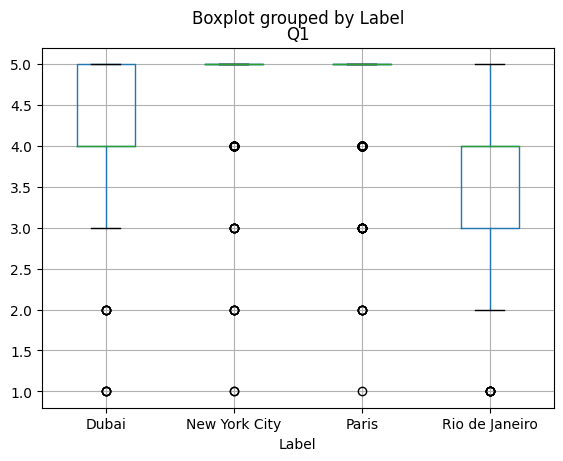

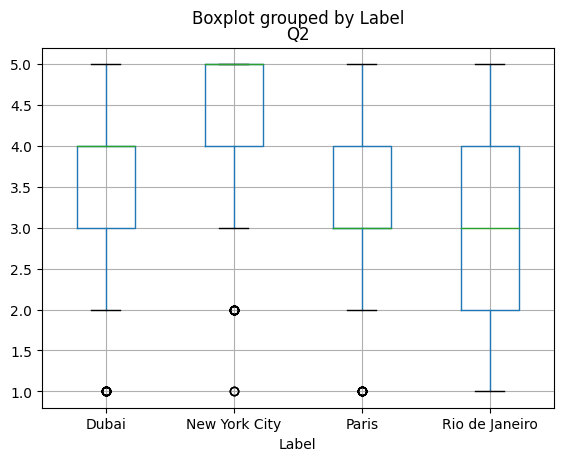

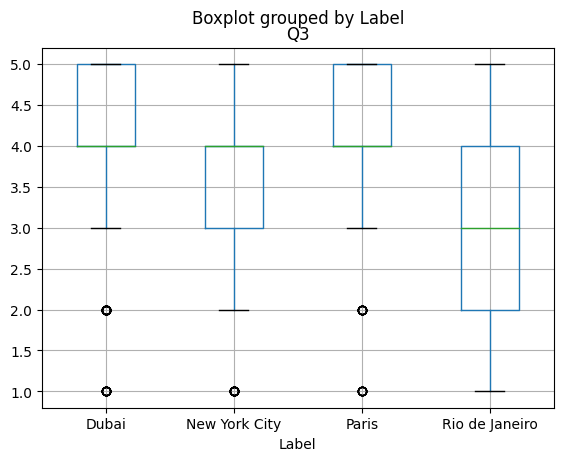

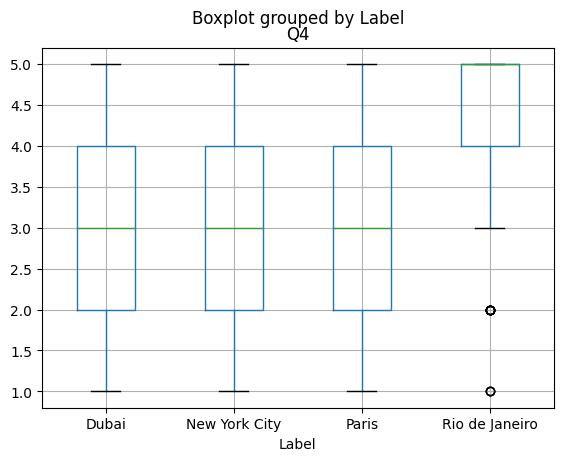

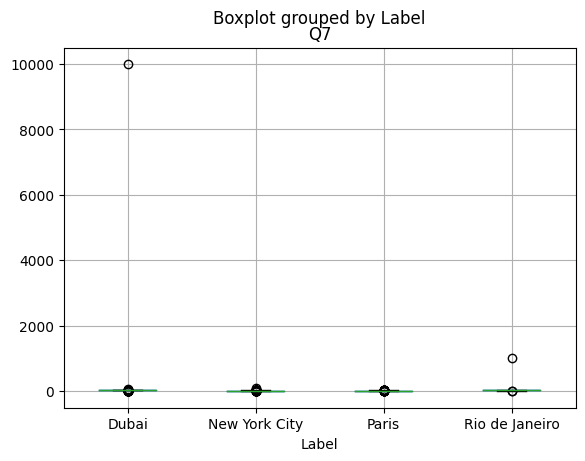

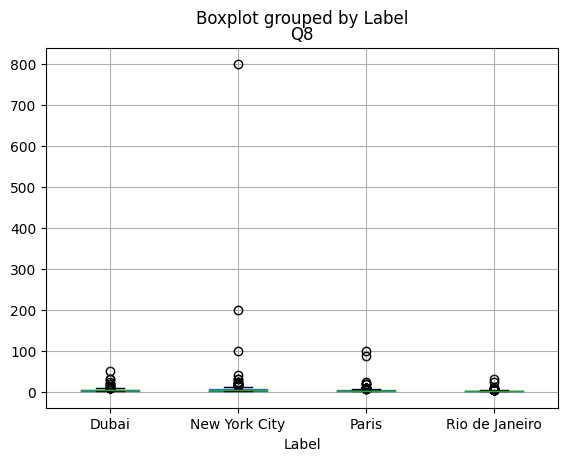

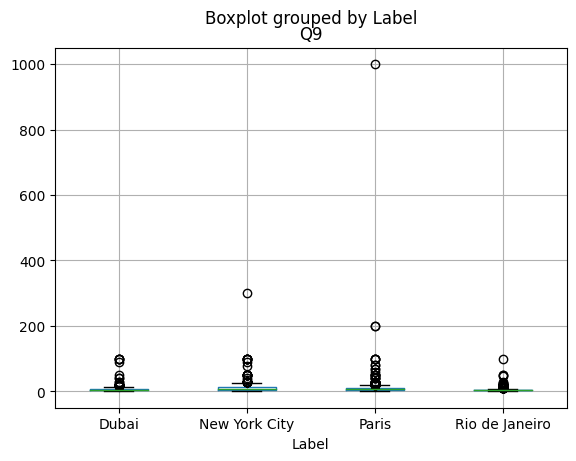

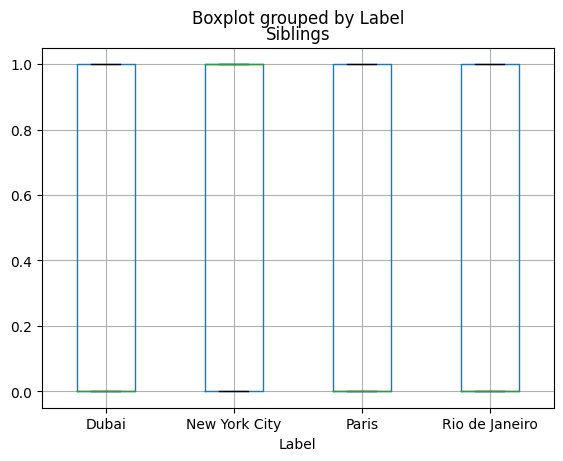

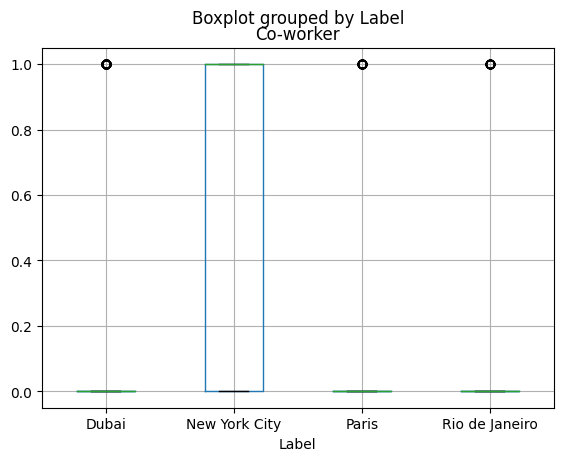

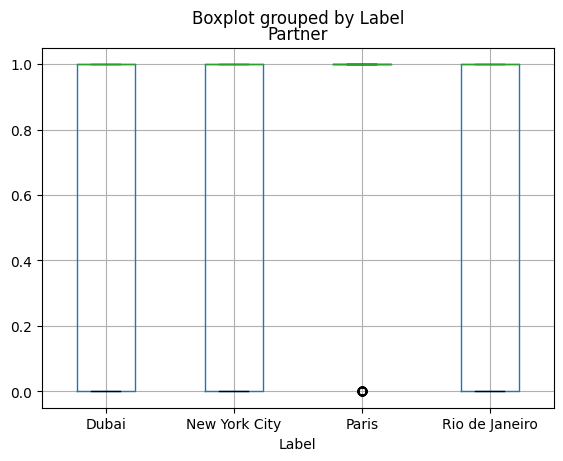

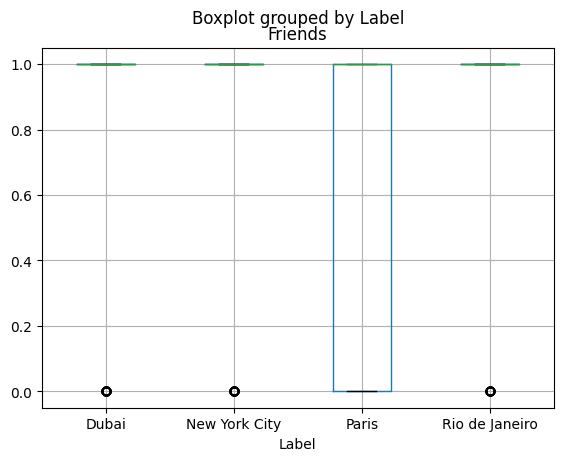

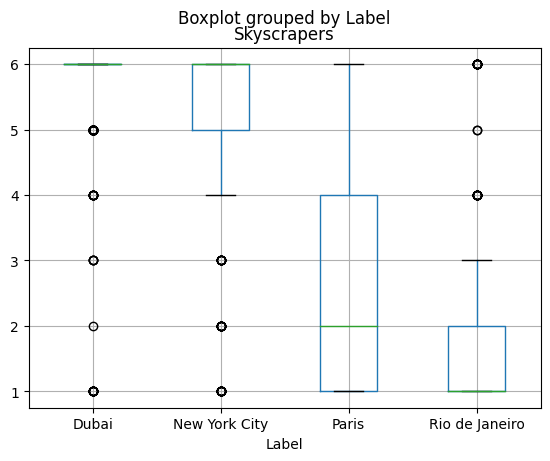

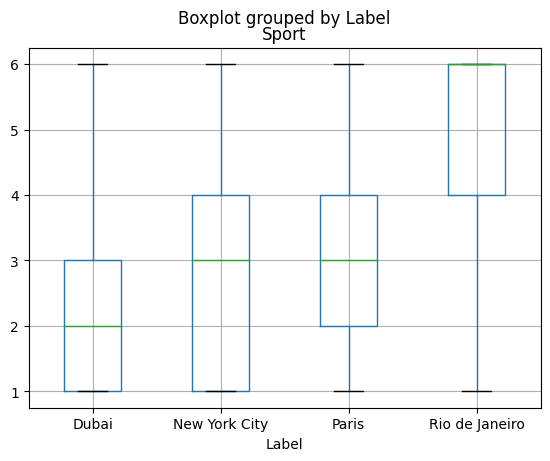

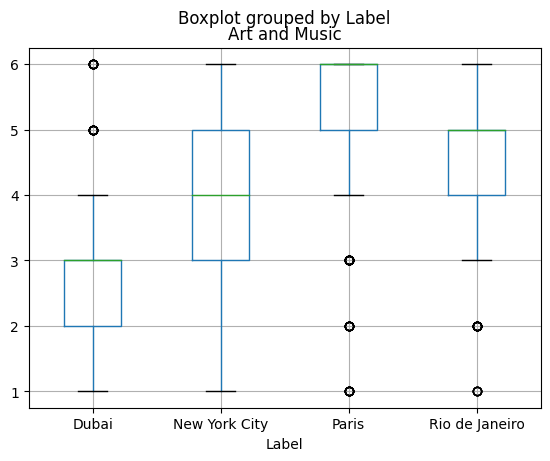

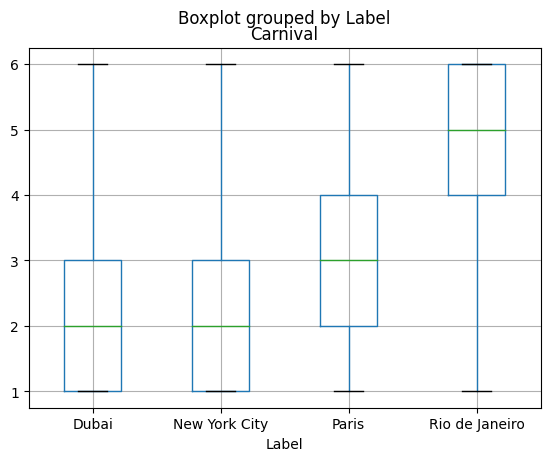

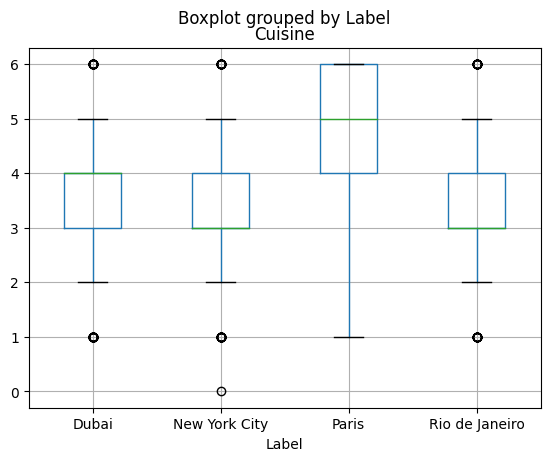

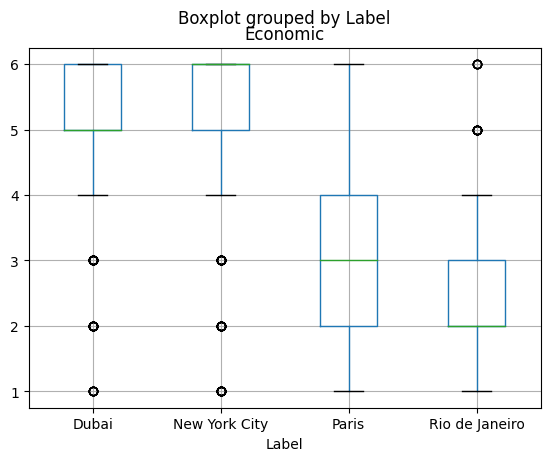

In [11]:
# Boxplots (before cleaning data)
# Analyze the distribution of numerical categories based on their label

data.boxplot(column='Q1', by='Label')
data.boxplot(column='Q2', by='Label')
data.boxplot(column='Q3', by='Label')
data.boxplot(column='Q4', by='Label')

data.boxplot(column='Q7', by='Label')
data.boxplot(column='Q8', by='Label')
data.boxplot(column='Q9', by='Label')

data.boxplot(column='Siblings', by='Label')
data.boxplot(column='Co-worker', by='Label')
data.boxplot(column='Partner', by='Label')
data.boxplot(column='Friends', by='Label')

data.boxplot(column='Skyscrapers', by='Label')
data.boxplot(column='Sport', by='Label')
data.boxplot(column='Art and Music', by='Label')
data.boxplot(column='Carnival', by='Label')
data.boxplot(column='Cuisine', by='Label')
data.boxplot(column='Economic', by='Label')


4. Cleaning data for Q7-9 and redoing boxplots. Findings:
- Q7 is useful. The data shows higher average temperatures in Dubai and Rio de Janeiro. However, there are many outliers.
- Q8-9 are not useful. The medians are all about the same and there are many outliers.

<Axes: title={'center': 'Q9'}, xlabel='Label'>

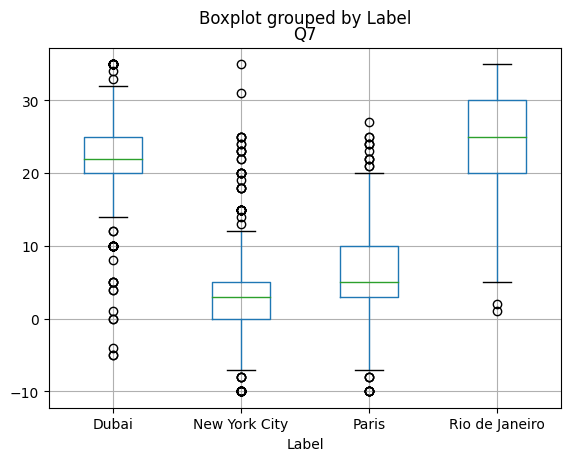

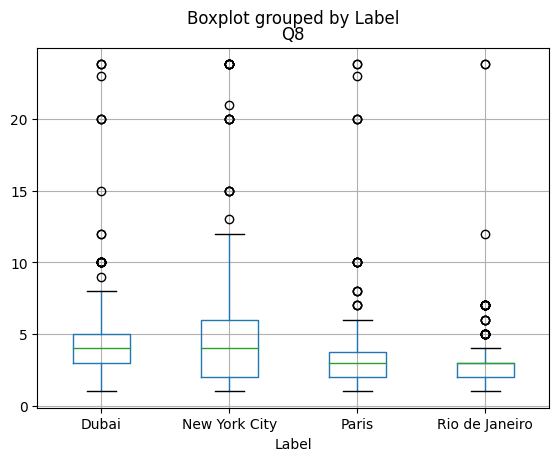

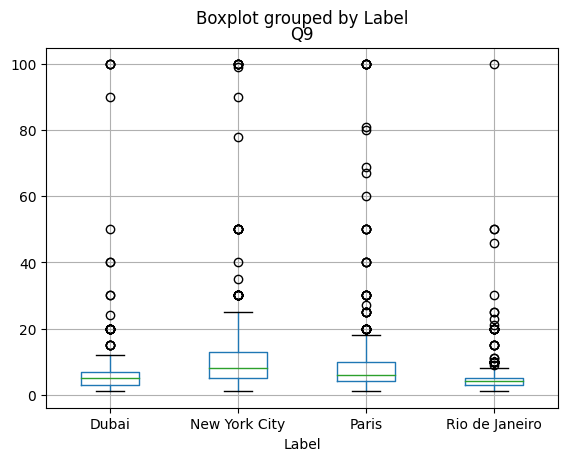

In [12]:

# Clean the data

for col in numeric_columns:
    lower_quantile = data[col].quantile(0.01)
    upper_quantile = data[col].quantile(0.99)
    data[col] = np.clip(data[col], lower_quantile, upper_quantile)

# Boxplots again

data.boxplot(column='Q7', by='Label')
data.boxplot(column='Q8', by='Label')
data.boxplot(column='Q9', by='Label')
